# Going beyond 'Sorry, I didn't get that': building AI assistants that scale using machine learning
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaX3LNhGcAe1HnPZSuWS0oH6af0LJHXcH7If1sQgLCFAT1chNGFg)


This notebook contains the code of the workshop which I did at PyData NYC 2018. If you have any questions or would like to learn more about anything included in this notebook, please raise an issue on this repo or shoot me an email at juste@rasa.com.

In this workshop you are going to build an assistant which will help you search for scientific papers easier!


This workshop consists of four main parts:


*   Part 0: Installation and setup
*   Part 1: Teaching an assistant to understand user inputs using Rasa NLU model
*   Part 2: Teaching an assistant to handle multi-turn conversations using dialogue management model.
*   Part 3: Improving the assistant using the real-time user feedback and interactive learning

## Part 0: Installation

### Let's start with jupyter configuration

The code block below makes sure that you get some information which you can use for debugging, cleans up the output from unecessary warnings and defines a function which whill print json outputs in a nicely formatted way.

In [1]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

### Installation of Rasa Stack
To complete this exercise you will need only two libraries - Rasa NLU and Rasa Core. If you have them already installed, you can skip this step, but make sure that your Ras NLU and Rasa Core versions are compatible with the ones used in this notebook.

In [ ]:
import sys
python = sys.executable

# In your environment run:
!{python} -m pip install -U rasa_core==0.11.11 rasa_nlu==0.13.6;
!{python} -m pip install sklearn_crfsuite;

Before moving on, let's test the installation - you should have rasa_nlu: 0.13.6 and rasa_core: 0.11.11 installed.

In [3]:
import rasa_nlu
import rasa_core


print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))

rasa_nlu: 0.13.6 rasa_core: 0.11.11


## Part 1: Natural Language Understanding

At first, let's teach our chatbot how to understand user inputs. To do that, we are going to build a Rasa NLU model which will parse user inputs and perform intent classification and entity extraction tasks. To train a Rasa NLU model we will need some real conversational data. Below, we have two possible conversations between the user and the assistant which we are going to use as the basis of training data.

**Conversation_1:**   
U: Hello.  
B: Hello! I am a papers search assistant. How can I help?  
U: I am looking for interesting papers about mathematics.  
B: I found 'Mathematics Theory'. Would you like to read the paper? I can send you a link.  
U: Yes, please.  
B: Here is a link https://link_to_paper.com.  
U: Thanks.  
B: Happy reading.  
U: Goodbye.  
B: Goodbye.  


**Conversation_2:**  
U: Hi    
B: Hello! I am a papers search assistant. How can I help?   
U: I am looking for interesting papers to read  
B: What type of papers are you interested in?  
U: About Physics  
B: I found 'Physic Theory'. Would you like to read the paper? I can send you a link.    
U: Sure. Can you also show tell who are authors of this paper?  
B: One moment please.  
B: This is the link: https://link_to_paper.com.  
B: The authors are xyz  
U: Thanks.  
B: Happy reading!  
U: Goodbye.  
B: Goodbye.  

### Creating the training data for language understanding model


Lets create some training data here by grouping user messages by their `intents`. The intent describes what the messages *mean*. Another important part of training data are `entities` - pieces of information which help a chatbot understand what specifically a user is asking about. Entities are labeled using the markdown link syntex: `[entity value](entity_type)` [More information about the data format](https://rasa.com/docs/nlu/dataformat/).

In [4]:
nlu_md = """

## intent:greet
- hey
- hello there
- hi
- hello there
- good morning
- good evening
- moin
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:goodbye
- cu
- good by
- cee you later
- good night
- good afternoon
- bye
- goodbye
- have a nice day
- see you around
- bye bye
- see you later

## intent:affirm
- yes
- indeed
- of course
- that sounds good
- correct
- definitely
- absolutely
- sure
- yep

## intent:deny
- no
- never
- I don't think so
- don't like that
- no way
- not really
- nope
- definitely no
- no no


## intent:paper_search
- Looking for papers about [chatbots](paper_type)
- Please suggest some interesting papers to read
- Looking for some new papers about [machine learning](paper_type)
- Any recommendataions for [statistics](paper_type) papers to read?
- I have some spare time and would like to read some [mathematics](paper_type) papers.
- Looking for papers to read
- Do you have new papers to recommend?
- Would like to read some papers about [physics](paper_type).
- Please recommend some interesting papers about [astronomy](paper_type).
- Looking for [econometrics](paper_type) papers.
- Looking for papers in [artificial intelligence](paper_type)
- Please share some papers to read
- Looking for [Physics](paper_type) to read.
- Can you recommend me [Mathematics](paper_type)?
- Any interesting papers [statistics](paper_type) you can recommend?


## intent:affirm+authors
- Yes. Also, tell me who are the authors.
- Yes, please. By the way, who are the authors of the paper?
- Sure. I woud also like to know the authors.
- Yes! And a list of authors please.
- Definitely. Also, please share who are the authors.
- Yes. Can I also see who the authors are?
- Sure. Also, please tell me who are the authors.
- Sure. Can you give me a list of authors as well?
- Yes. Tell me who wrote this paper as well.
- Sure. Who wrote this paper?
- Sounds good. I am also interested in who wrote this paper?

## intent:authors
- Tell me who are the authors first
- Please tell me the who are the authors
- I would like to see who are the authors first
- Before I decide I would like to see the authors
- Show me the authors please
- Can I see the authors first?
- Who wrote this paper?
- I would like to know who is the author of this paper.
- Tell me who wrote the paper.
- Who is the author?
- Do you know who is the author of the paper?
- Who wrote it?
- Do you know the author?

## intent:send_link
- Send me a link to the paper
- Can I get a link
- Send me a link
- Please send me a link so I can read it
- Send me a link to it please
- I would like to get a link

## intent:inform
- about [statistics](paper_type)
- maybe [mathematics](paper_type)
- about [geography](paper_type)
- for [machine learning](paper_type)
- about [differentiation](paper_type)
- maybe about [calculus](paper_type)

## intent:thanks
- thanks
- thank you
- thank you very much
- thanks a lot
- thank you so much
- thank you loads
"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


### Defining the NLU model

Once the training data is ready, we can define our NLU model. We can do that by constructing the processing pipeline which defines how structured data is extracted from unstructured user inputs. 

In [5]:
config = """
language: "en"

pipeline:
- name: "tokenizer_whitespace"                              #defines how unstructured sentences will be tokenized
- name: "ner_crf"                                           #defines the model which will be used for entity extraction
- name: "intent_featurizer_count_vectors"                   #creates sentence representation
- name: "intent_classifier_tensorflow_embedding"            #defines a classifier for intent classification
  intent_tokenization_flag: true                            #sets the flag for intent label tokenization
  intent_split_symbol: "+"                                  #defines the character on which intent labels should be tokenized
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


### Training the Rasa NLU Model

We're going to train a model to recognise user inputs, so that when you send a message like "hello" to your bot, it will recognise this as a `"greet"` intent.

In [6]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data, verbose=True)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 99 (10 distinct intents)
	- Found intents: 'paper_search', 'thanks', 'deny', 'send_link', 'affirm+authors', 'inform', 'affirm', 'goodbye', 'greet', 'authors'
	- entity examples: 17 (1 distinct entities)
	- found entities: 'paper_type'

INFO:rasa_nlu.model:Starting to train component tokenizer_whitespace
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_crf
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_count_vectors
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_classifier_tensorflow_embedding
INFO:rasa_nlu.classifiers.embedding_intent_classifier:Accuracy is updated every 10 epochs
Epochs: 100%|█████████████████████████████████████████████████| 300/300 [00:03

### Using & evaluating the NLU model

Let's see how the model is performing on some of the inputs:

In [7]:
pprint(interpreter.parse("Yes. Also, who is the author?"))

{
  "intent_ranking": [
    {
      "confidence": 0.9450413584709167,
      "name": "affirm+authors"
    },
    {
      "confidence": 0.07367540150880814,
      "name": "affirm"
    },
    {
      "confidence": 0.0,
      "name": "paper_search"
    },
    {
      "confidence": 0.0,
      "name": "authors"
    },
    {
      "confidence": 0.0,
      "name": "deny"
    },
    {
      "confidence": 0.0,
      "name": "greet"
    },
    {
      "confidence": 0.0,
      "name": "send_link"
    },
    {
      "confidence": 0.0,
      "name": "thanks"
    },
    {
      "confidence": 0.0,
      "name": "inform"
    },
    {
      "confidence": 0.0,
      "name": "goodbye"
    }
  ],
  "text": "Yes. Also, who is the author?",
  "entities": [],
  "intent": {
    "confidence": 0.9450413584709167,
    "name": "affirm+authors"
  }
}


Instead of evaluating it by hand, the model can also be evaluated on a test data set (though for simplicity we are going to use the same for test and train):

INFO:tensorflow:Restoring parameters from C:\Users\justi\Desktop\PyDataNYC\./models/nlu\default\current\intent_classifier_tensorflow_embedding.ckpt
INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 99 (10 distinct intents)
	- Found intents: 'paper_search', 'thanks', 'deny', 'send_link', 'affirm+authors', 'inform', 'affirm', 'goodbye', 'greet', 'authors'
	- entity examples: 17 (1 distinct entities)
	- found entities: 'paper_type'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 99 examples that have a defined intent out of 99 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.9898455454011009
INFO:rasa_nlu.evaluate:Precision: 0.9906204906204906
INFO:rasa_nlu.evaluate:Accuracy:  0.98989898989899
INFO:rasa_nlu.evaluate:Classification report: 
                precision    recall  f1-score   support

        affirm       1.00

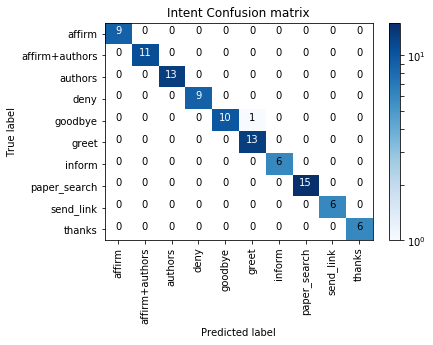

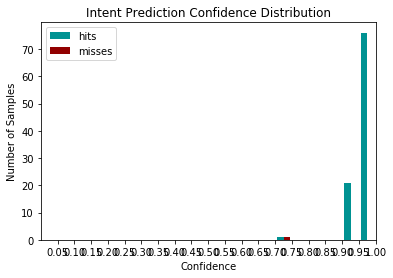

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_crf 
INFO:rasa_nlu.evaluate:F1-Score:  1.0
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  1.0
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

  no_entity       1.00      1.00      1.00       414
 paper_type       1.00      1.00      1.00        20

avg / total       1.00      1.00      1.00       434



In [8]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu.md", model_directory)

# Part 2: Handling the dialogue

We have taught our assistant how to understand user inputs. Now, it's time to teach it how to make responses by training a dialogue management model using Rasa Core.

### Writing Stories

The training data for dialogue management models is called `stories`. A story is an actual conversation where user inputs are expressed as intents as well as corresponding entities, and chatbot responses are expressed as actions.


Let's take a look into the format of the stories in more detail:

A story starts with `##` and you can give it a name. 
Lines that start with `*` are messages sent by the user. Although you don't write the *actual* message, but rather the intent (and the entities) that represent what the user *means*. 
Lines that start with `-` are *actions* taken by your bot. In this case all of our actions are just messages sent back to the user, like `utter_greet`, but in general an action can do anything, including calling an API and interacting with the outside world. 

To start generating some training data, let's use the original conversations between the user and the assistant again: 

**Conversation_1:**   
U: Hello.  
B: Hello! I am a papers search assistant. How can I help?  
U: I am looking for interesting papers about mathematics.  
B: I found 'Mathematics Theory'. Would you like to read the paper? I can send you a link.  
U: Yes, please.  
B: Here is a link https://link_to_paper.com.  
U: Thanks.  
B: Happy reading.  
U: Goodbye.  
B: Goodbye.  


**Conversation_2:**  
U: Hi    
B: Hello! I am a papers search assistant. How can I help?   
U: I am looking for interesting papers to read  
B: What type of papers are you interested in?  
U: About Physics  
B: I found 'Physic Theory'. Would you like to read the paper? I can send you a link.    
U: Sure. Can you also show tell who are authors of this paper?  
B: One moment please.  
B: This is the link: https://link_to_paper.com.  
B: The authors are xyz  
U: Thanks.  
B: Happy reading!  
U: Goodbye.  
B: Goodbye.  

In [9]:
stories_md = """


## Suggestion path 1
* greet
  - utter_greet
* paper_search
  - utter_what_type
* inform{"paper_type":"machine learning"}
  - action_paper_search
  - utter_approve
* affirm
  - utter_send_link
  - utter_happy_reading
* goodbye
  - utter_goodbye

## Suggestion path 2
* greet
  - utter_greet
* paper_search{"paper_type":"chatbots"}
  - action_paper_search
  - utter_approve
* affirm+authors
  - utter_one_moment
  - utter_send_link
  - utter_authors
* thanks
  - utter_happy_reading
* goodbye
  - utter_goodbye

## Suggestion path 3
* greet
  - utter_greet
* paper_search{"paper_type":"statistics"}
  - action_paper_search
  - utter_approve
* deny
  - utter_goodbye
  
## Suggestion path 4
* greet
  - utter_greet
* paper_search{"paper_type":"statistics"}
  - action_paper_search
  - utter_approve
* affirm
  - utter_send_link
* authors
  - utter_one_moment
  - utter_authors
* thanks
  - utter_happy_reading
* goodbye
  -utter_goodbye
  

## Suggestion path 5
* greet
  - utter_greet
* paper_search{"paper_type":"mathematics"}
  - action_paper_search
  - utter_approve
* authors
  - utter_one_moment
  - utter_authors
* send_link
  - utter_send_link
* goodbye
  -utter_goodbye
  
  
## Suggestion path 6
* greet
  - utter_greet
* paper_search
  - utter_what_type
* inform{"paper_type":"chatbots"}
  - action_paper_search
  - utter_approve
* authors
  - utter_one_moment
  - utter_authors
* send_link
  - utter_send_link
* thanks
  - utter_happy_reading
* goodbye
  -utter_goodbye 
  
  
## Suggestion path 7
* greet
  - utter_greet
* paper_search
  - utter_what_type
* inform{"paper_type":"chatbots"}
  - action_paper_search
  - utter_approve
* affirm+authors
  - utter_one_moment
  - utter_send_link
  - utter_authors
* send_link
  - utter_send_link
* thanks
  - utter_happy_reading
* goodbye
  -utter_goodbye 

"""

%store stories_md > stories.md

print("Done!")

Writing 'stories_md' (str) to file 'stories.md'.
Done!


### Defining a Domain

The domain specifies the universe that the assistant operates in. In AI assistant's world this universe consists of intents and entities as well as the actions which appear in training stories. The domain can also contain the templates for the answers an assistant should use to respond to the user and slots which will help the assistant to keep track of the context. Let's look into the domain of our bot:

In [10]:
domain_yml = """

intents:
- greet
- goodbye
- paper_search
- inform
- affirm
- affirm+authors
- authors
- thanks
- deny
- send_link

slots:
  paper_type:
    type: text
  link:
    type: text
  authors:
    type: text
    
entities:
- paper_type

actions:
- utter_greet
- utter_goodbye
- utter_send_link
- utter_one_moment
- utter_what_type
- utter_happy_reading
- utter_authors
- utter_approve
- action_paper_search

templates:
  utter_greet:
  - text: "Hey! I am paper search assistant. How can I help"

  utter_goodbye:
  - text: "Have a great day!"

  utter_send_link:
  - text: "Here is a link: {link}"
  
  utter_one_moment:
  - text: "One moment."
  
  utter_what_type:
  - text: "What type of paper would you like me to find?"
  
  utter_happy_reading:
  - text: "Enjoy your reading."
  
  utter_approve:
  - text: "Would you like to read this paper? I can send you a link."
  
  utter_authors:
  - text: "Here is a list of authors: {authors}."
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Adding Custom Actions

The responses of the assistant can be more than just simple text responses - it can call an API to retrieve some data which can later be used to create a response to user input. Let's create a custom action for our bot which, when predicted, will make an API and a look for a paper to suggest based on user request. Since we save entities as slots, out assistant will know which specific paper it should look for.

In [11]:
custom_action = """

from rasa_core_sdk import Action
from rasa_core_sdk.events import SlotSet

import requests

class ApiAction(Action):
    def name(self):
        return "action_paper_search"

    def run(self, dispatcher, tracker, domain):

        paper_type = tracker.get_slot('paper_type')
        
        response = requests.get('http://dblp.org/search/publ/api?q={}&format=json&h=1'.format(paper_type)).json()
        title = response['result']['hits']['hit'][0]['info']['title']
        authors = response['result']['hits']['hit'][0]['info']['authors']['author'][0]
        link = response['result']['hits']['hit'][0]['info']['url']

        dispatcher.utter_message("I found a paper called {}".format(title))
        return [SlotSet("link",link), SlotSet("authors",authors)]
        
"""
%store custom_action > actions.py

Writing 'custom_action' (str) to file 'actions.py'.


### Training your Dialogue Model

Now we are good to train the dialogue management model. We can specify what policies should be used to train it - in this case, the model is a neural network implemented in Keras which learns to predict which action to take next. We can also tweak the parameters of what percentage of training examples should be used for validation and how many epochs should be used for training.

In [12]:
from rasa_core.policies import KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# there is a threshold for the NLU predictions as well as the action predictions

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy()])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.0,
    epochs=200
)

agent.persist('models/dialogue')

INFO:apscheduler.scheduler:Scheduler started
C:\Users\justi\Anaconda3\lib\site-packages\pykwalify\core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)
Processed Story Blocks: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 226.37it/s, # trackers=6]
Processed actions: 85it [00:00, 747.25it/s, # examples=85]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 5, 26)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                7552      
_________________________________________________________________
dense (Dense)                (None, 12)                396       
_________________________________________________________________
activation (Activation)      (None, 12)                0         
Total params: 7,948
Trainable params: 7,948
Non-trainable params: 0
_________________________________________________________________


INFO:rasa_core.policies.keras_policy:Fitting model with 85 total samples and a validation split of 0.0


Epoch 1/200
85/85 [==============================] - ETA: 1s - loss: 2.4950 - acc: 0.062 - 1s 8ms/step - loss: 2.4778 - acc: 0.1176
Epoch 2/200
85/85 [==============================] - ETA: 0s - loss: 2.4505 - acc: 0.156 - 0s 188us/step - loss: 2.4316 - acc: 0.2353
Epoch 3/200
85/85 [==============================] - ETA: 0s - loss: 2.3607 - acc: 0.406 - 0s 188us/step - loss: 2.3938 - acc: 0.3176
Epoch 4/200
85/85 [==============================] - ETA: 0s - loss: 2.3631 - acc: 0.281 - 0s 164us/step - loss: 2.3670 - acc: 0.3176
Epoch 5/200
85/85 [==============================] - ETA: 0s - loss: 2.3421 - acc: 0.281 - 0s 199us/step - loss: 2.3242 - acc: 0.3412
Epoch 6/200
85/85 [==============================] - ETA: 0s - loss: 2.2730 - acc: 0.406 - 0s 164us/step - loss: 2.3008 - acc: 0.3529
Epoch 7/200
85/85 [==============================] - ETA: 0s - loss: 2.2647 - acc: 0.468 - 0s 188us/step - loss: 2.2759 - acc: 0.3765
Epoch 8/200
85/85 [==============================] - ETA: 0s - l

Epoch 62/200
85/85 [==============================] - ETA: 0s - loss: 1.3379 - acc: 0.593 - 0s 164us/step - loss: 1.4132 - acc: 0.4824
Epoch 63/200
85/85 [==============================] - ETA: 0s - loss: 1.4928 - acc: 0.531 - 0s 153us/step - loss: 1.3479 - acc: 0.5765
Epoch 64/200
85/85 [==============================] - ETA: 0s - loss: 1.5709 - acc: 0.312 - 0s 164us/step - loss: 1.4060 - acc: 0.4588
Epoch 65/200
85/85 [==============================] - ETA: 0s - loss: 1.3323 - acc: 0.468 - 0s 176us/step - loss: 1.4008 - acc: 0.4588
Epoch 66/200
85/85 [==============================] - ETA: 0s - loss: 1.3782 - acc: 0.500 - 0s 164us/step - loss: 1.3614 - acc: 0.4706
Epoch 67/200
85/85 [==============================] - ETA: 0s - loss: 1.2936 - acc: 0.531 - 0s 141us/step - loss: 1.3624 - acc: 0.5059
Epoch 68/200
85/85 [==============================] - ETA: 0s - loss: 1.4203 - acc: 0.500 - 0s 153us/step - loss: 1.3689 - acc: 0.5059
Epoch 69/200
85/85 [==============================] - E

85/85 [==============================] - ETA: 0s - loss: 0.9332 - acc: 0.687 - 0s 153us/step - loss: 0.8855 - acc: 0.7529
Epoch 123/200
85/85 [==============================] - ETA: 0s - loss: 0.8999 - acc: 0.750 - 0s 176us/step - loss: 0.9033 - acc: 0.7647
Epoch 124/200
85/85 [==============================] - ETA: 0s - loss: 0.8002 - acc: 0.843 - 0s 153us/step - loss: 0.8717 - acc: 0.7647
Epoch 125/200
85/85 [==============================] - ETA: 0s - loss: 0.8955 - acc: 0.718 - 0s 164us/step - loss: 0.9130 - acc: 0.7529
Epoch 126/200
85/85 [==============================] - ETA: 0s - loss: 0.9516 - acc: 0.687 - 0s 164us/step - loss: 0.8837 - acc: 0.7647
Epoch 127/200
85/85 [==============================] - ETA: 0s - loss: 0.8284 - acc: 0.750 - 0s 176us/step - loss: 0.8405 - acc: 0.7882
Epoch 128/200
85/85 [==============================] - ETA: 0s - loss: 0.8883 - acc: 0.750 - 0s 164us/step - loss: 0.8839 - acc: 0.7529
Epoch 129/200
85/85 [==============================] - ETA: 0s

85/85 [==============================] - ETA: 0s - loss: 0.5475 - acc: 0.906 - 0s 153us/step - loss: 0.5029 - acc: 0.8941
Epoch 183/200
85/85 [==============================] - ETA: 0s - loss: 0.3445 - acc: 0.937 - 0s 141us/step - loss: 0.4934 - acc: 0.8824
Epoch 184/200
85/85 [==============================] - ETA: 0s - loss: 0.5751 - acc: 0.875 - 0s 164us/step - loss: 0.4851 - acc: 0.9059
Epoch 185/200
85/85 [==============================] - ETA: 0s - loss: 0.5239 - acc: 0.906 - 0s 176us/step - loss: 0.5156 - acc: 0.8824
Epoch 186/200
85/85 [==============================] - ETA: 0s - loss: 0.6271 - acc: 0.812 - 0s 153us/step - loss: 0.4915 - acc: 0.8824
Epoch 187/200
85/85 [==============================] - ETA: 0s - loss: 0.5405 - acc: 0.812 - 0s 164us/step - loss: 0.5129 - acc: 0.8588
Epoch 188/200
85/85 [==============================] - ETA: 0s - loss: 0.5979 - acc: 0.843 - 0s 176us/step - loss: 0.4880 - acc: 0.9176
Epoch 189/200
85/85 [==============================] - ETA: 0s

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Model directory models/dialogue exists and contains old model files. All files will be overwritten.
INFO:rasa_core.agent:Persisted model to 'C:\Users\justi\Desktop\PyDataNYC\models\dialogue'


## Testing the assistant!

Congratulations! You have just trained the dialogue management model of your assistant which means that you are ready to test your assistant.

The code block below defines the webhook configuration of the action server:

In [13]:
endpoint = """
action_endpoint:
  url: "http://localhost:5055/webhook"
"""
%store endpoint > endpoints.yml

Writing 'endpoint' (str) to file 'endpoints.yml'.


You will have to start the actions server on the command line. To do that, use code block below  to start the command line and run the following command: **python -m rasa_core_sdk.endpoint --actions actions**

In [25]:
from IPython.display import IFrame
IFrame("http://localhost:8888/terminals/1", width=1000, height=500)

### Talking to the Bot (with NLU)

Now it's time to test the assistant. The code below will launch the start_action_server and run_bot functions in parallel and will launch the assistant for you to test.

In [ ]:
import IPython
from IPython.display import clear_output
from rasa_core.agent import Agent
from rasa_core.interpreter import NaturalLanguageInterpreter
from rasa_core.utils import EndpointConfig
import time

messages = ["Hi! you can chat in this window. Type 'stop' to end the conversation."]
interpreter = NaturalLanguageInterpreter.create('models/current/nlu')
endpoint = EndpointConfig('http://localhost:5055/webhook')
agent = Agent.load('models/dialogue', interpreter=interpreter, action_endpoint = endpoint)

print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_text(a)
    for response in responses:
        print(response["text"])

### Evaluation of the dialogue model
As with the NLU model, instead of just subjectively testing the model, we can also evaluate the model on a dataset. You'll be using the training data set again, but usually you'd use a test data set separate from the training data.

In [120]:
!{python} -m rasa_core.evaluate -d models/dialogue -s stories.md -o matrix.pdf --failed failed_stories.md

/home/juste/anaconda3/lib/python3.6/site-packages/pykwalify/core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)
2018-10-07 20:59:27.574718: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
Processed Story Blocks: 100%|█████| 6/6 [00:00<00:00, 1412.54it/s, # trackers=1]
INFO:__main__:Evaluating 6 stories
Progress:
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.90it/s]
INFO:__main__:Finished collecting predictions.
INFO:__main__:Evaluation Results on CONVERSATION level:
INFO:__main__:	Correct:   6 / 6
INFO:

### Interactive learning
To start an interactive learning session, we will use a command line inside the jupyter again. Once the terminal is open, you can start the session by running: **python -m rasa_core.train --online -o models/dialogue -d domain.yml -s stories.md -u models/nlu/default/current --endpoints endpoints.yml**

In [1]:
from IPython.display import IFrame
IFrame("http://localhost:8888/terminals/2", width=1000, height=500)

### Tips

- Bootstrap from little conversational data and allow users to use your application early on.
- Use interactive learning to start generating training data and training your model.
- Connect your assistant to the outside world by using the most popular messaging or voice platforms.

### Resources 
- [Official Rasa documentation](https://rasa.com/docs/getting-started/overview/)
- [Rasa Community Forum](https://forum.rasa.com)
- [Supervised vord vectors from scratch in Rasa NLU](https://medium.com/rasa-blog/supervised-word-vectors-from-scratch-in-rasa-nlu-6daf794efcd8)
- [How to handle multiple intents per input using Rasa NLU TensorFlow pipeline](https://medium.com/rasa-blog/how-to-handle-multiple-intents-per-input-using-rasa-nlu-tensorflow-pipeline-75698b49c383)
- [Going beyond ‘Hey Google’: building a Rasa-powered Google Assistant](https://medium.com/rasa-blog/going-beyond-hey-google-building-a-rasa-powered-google-assistant-5ff916409a25)